In [1]:
import os
import sys 
sys.path.append(os.path.abspath('..'))
sys.path.append(os.path.abspath('../../latent_analysis/'))
sys.path.append(os.path.abspath('../../dPCA/python/'))
import json
from pathlib import Path
from utils import create_directory
from model import test
import plot as plot
import LTransform as LT
import numpy as np
from dPCA import dPCA
import matplotlib.pyplot as plt
import torch as th
import pandas as pd
import seaborn as sns

import rsatoolbox.rdm as rsr
import rsatoolbox
import rsatoolbox.data as rsd # abbreviation to deal with dataset

In [2]:
# read files 
data_dir = create_directory(directory_name='loss0_if')

model_num = 0
model_name = "model{:02d}".format(model_num)

phases = ['growing_up','NF1'] # ,'FF1','NF2','FF2'

w1 = []
w2 = []
w3 = []
w4 = []
w5 = []
w6 = []
for phase in phases: 
    # check if phase is equal to 1 or 3
    weight_file = list(Path(data_dir).glob(f'{model_name}_phase={phase}_*_weights'))[0]
    w = th.load(weight_file)

    w1.append(np.ravel(np.array(w['gru.weight_ih_l0'])))
    w2.append(np.ravel(np.array(w['gru.weight_hh_l0'])))
    w3.append(np.ravel(np.array(w['gru.bias_ih_l0'])))
    w4.append(np.ravel(np.array(w['gru.bias_hh_l0'])))
    w5.append(np.ravel(np.array(w['fc.weight'])))
    w6.append(np.ravel(np.array(w['fc.bias'])))

w1 = np.array(w1)
w2 = np.array(w2)
w3 = np.array(w3)
w4 = np.array(w4)
w5 = np.array(w5)
w6 = np.array(w6)

obs_des = {'conds': np.array(np.array(phases))}

w1 = rsd.Dataset(measurements=w1,obs_descriptors=obs_des)
w2 = rsd.Dataset(measurements=w2,obs_descriptors=obs_des)
w3 = rsd.Dataset(measurements=w3,obs_descriptors=obs_des)
w4 = rsd.Dataset(measurements=w4,obs_descriptors=obs_des)
w5 = rsd.Dataset(measurements=w5,obs_descriptors=obs_des)
w6 = rsd.Dataset(measurements=w6,obs_descriptors=obs_des)

rdm1 = rsr.calc_rdm(w1,descriptor='conds')
rdm2 = rsr.calc_rdm(w2,descriptor='conds')
rdm3 = rsr.calc_rdm(w3,descriptor='conds')
rdm4 = rsr.calc_rdm(w4,descriptor='conds')
rdm5 = rsr.calc_rdm(w5,descriptor='conds')
rdm6 = rsr.calc_rdm(w6,descriptor='conds')

/Users/mahdiyar/miniconda3/envs/dl/lib/python3.11/site-packages/rsatoolbox/data/computations.py:36: RuntimeWarning: invalid value encountered in multiply
  average = np.nan * np.empty(


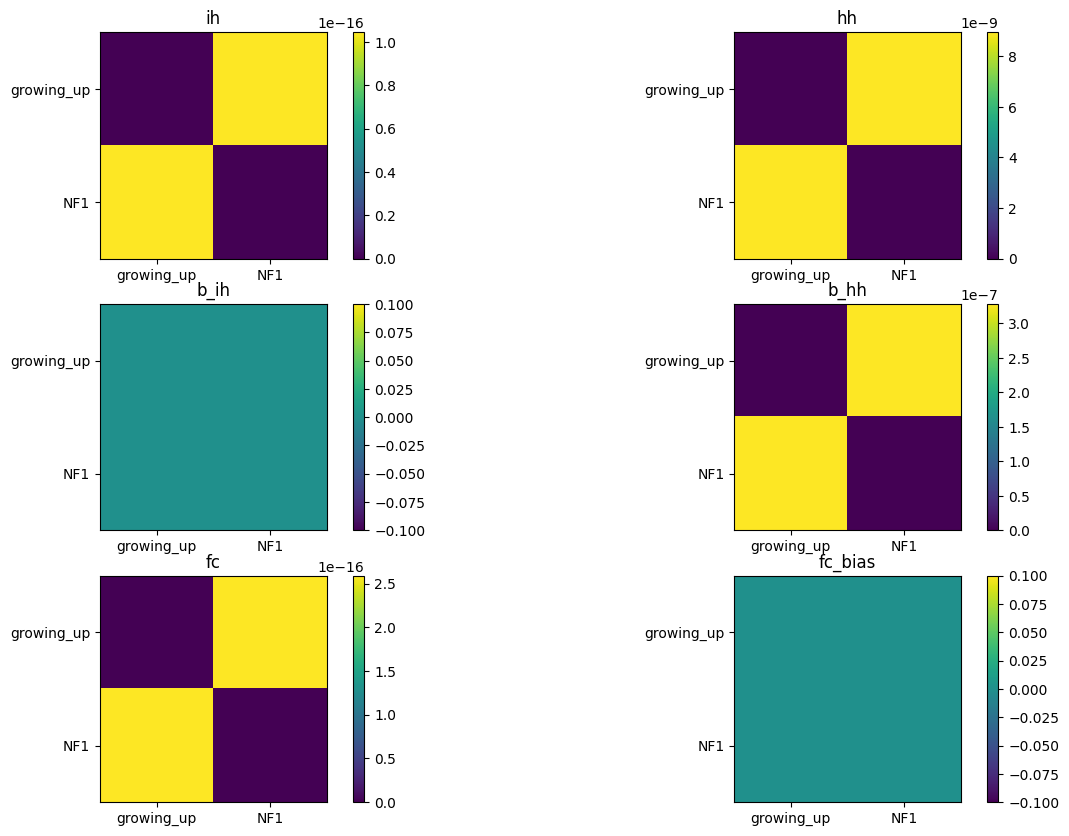

In [3]:
rdm_list = [rdm1, rdm2, rdm3, rdm4, rdm5, rdm6]
labels = phases

plt.figure(figsize=(15, 10))
weight = ['ih', 'hh', 'b_ih','b_hh', 'fc', 'fc_bias']
for i, rdm in enumerate(rdm_list, start=1):
    plt.subplot(3, 2, i)
    plt.title(weight[i-1])
    plt.imshow(rdm.get_matrices()[0], interpolation='none')
    plt.colorbar()

    plt.xticks([0, 1,], labels)
    plt.yticks([0, 1,], labels)

plt.show()

/Users/mahdiyarshahbazi/miniconda3/envs/dl/lib/python3.10/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/Users/mahdiyarshahbazi/miniconda3/envs/dl/lib/python3.10/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/Users/mahdiyarshahbazi/miniconda3/envs/dl/lib/python3.10/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/Users/mahdiyarshahbazi/miniconda3/envs/dl/lib/python3.10/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value o

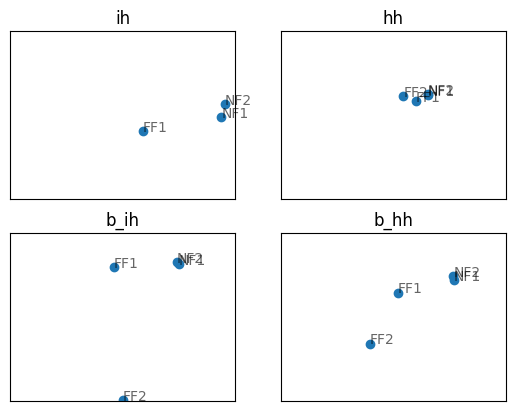

In [17]:
fig = rsatoolbox.vis.show_2d(
    rsatoolbox.rdm.RDMs(
        np.concatenate(
            [rdm1.get_matrices(),
             rdm2.get_matrices(),
             rdm3.get_matrices(),
             rdm4.get_matrices()],
             axis=0),
             rdm_descriptors=dict(weight=('ih', 'hh', 'b_ih','b_hh')),
             pattern_descriptors=obs_des
        ),
        rdm_descriptor='weight',method='MDS',pattern_descriptor='conds')

#fig.axes[0].set_ylim([-7e-6,7e-6])
#fig.axes[0].set_xlim([-7e-6,7e-6])

#fig.axes[1].set_ylim([-2e-6,2e-6])
#fig.axes[1].set_xlim([-2e-6,2e-6])